In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.files import results_dir, config_dir
from src.iaf.config import SimulationConfig
from src.iaf.source_population import SourcePopulationGabor
from src.plotting import errorPlot

In [19]:
def gather_metadata(experiment_folder):
    runs = list(experiment_folder.glob("ratio_*_edge_*_repeat_*.joblib"))
    args = joblib.load(experiment_folder / "args.joblib")

    ratios = []
    edges = []
    repeats = []
    for r in runs:
        stem = r.stem
        _, ratio, _, edge, _, repeat = stem.split("_")
        ratios.append(int(ratio))
        edges.append(int(edge))
        repeats.append(int(repeat))

    base_config = SimulationConfig.from_yaml(config_dir() / (args.config + ".yaml"))

    dt = joblib.load(runs[0])["sim"].dt
    metadata = dict(
        args=args,
        config_name=args.config,
        base_config=base_config,
        dp_ratios=args.distal_dp_ratios,
        edge_probabilities=args.edge_probabilities,
        num_neurons=args.num_neurons,
        num_repeats=args.repeats,
        duration=args.duration,
        dt=dt,
        ratios=ratios,
        edges=edges,
        repeats=repeats,
        data_paths=runs,
    )
    return metadata

def gather_results(metadata):
    results = []
    for path in metadata["data_paths"]:
        results.append(joblib.load(path))
    return results

def gather_rates(metadata):
    num_ratios = len(metadata["dp_ratios"])
    num_edges = len(metadata["edge_probabilities"])
    firing_rates = np.zeros((num_ratios, num_edges, metadata["num_repeats"], metadata["num_neurons"], metadata["duration"]))
    for ratio, edge, repeat, path in zip(metadata["ratios"], metadata["edges"], metadata["repeats"], metadata["data_paths"]):
        spk_times = joblib.load(path)["spike_times"]
        
        for ineuron in range(metadata["num_neurons"]):
            psth = np.zeros((metadata["duration"] * int(1/metadata["dt"])))
            psth[spk_times[ineuron]] = 1
            psth = np.sum(np.reshape(psth, (metadata["duration"], -1)), axis=1)
            firing_rates[ratio, edge, repeat, ineuron] = psth
    return firing_rates

def gather_weights(metadata, average_method: str = "fraction", average_window: int | float = 0.05, normalize: bool = True):
    num_ratios = len(metadata["dp_ratios"])
    num_edges = len(metadata["edge_probabilities"])
    num_inputs = SourcePopulationGabor.num_inputs
    proximal = np.zeros((num_ratios, num_edges, metadata["num_repeats"], metadata["num_neurons"], num_inputs))
    distal_simple = np.zeros((num_ratios, num_edges, metadata["num_repeats"], metadata["num_neurons"], num_inputs))
    distal_complex = np.zeros((num_ratios, num_edges, metadata["num_repeats"], metadata["num_neurons"], num_inputs))

    duration = metadata["duration"]
    if average_method == "fraction":
        if average_window >= 0.5:
            raise ValueError("Average window must be less than 0.5 for fraction averaging")
        num_timesteps = int(duration * average_window)
    else:
        if average_window >= duration/2:
            raise ValueError("Average window must be less than half the duration for full averaging")
        num_timesteps = duration

    def get_norm_factor(neuron):
        groups = ["proximal", "distal-simple", "distal-complex"]
        if normalize:
            max_weight = {sg: neuron.synapse_groups[sg].max_weight for sg in groups}
            num_synapses = {sg: neuron.synapse_groups[sg].num_synapses for sg in groups}
            num_inputs = {sg: neuron.synapse_groups[sg].source_params.num_presynaptic_neurons for sg in groups}
            return {sg: max_weight[sg] * num_synapses[sg] / num_inputs[sg] for sg in groups}
        else:
            return {sg: 1 for sg in groups}
        
    for ratio, edge, repeat, path in zip(metadata["ratios"], metadata["edges"], metadata["repeats"], metadata["data_paths"]):
        results = joblib.load(path)
        weights = results["weights"]
        for ineuron in range(metadata["num_neurons"]):
            norm_factor = get_norm_factor(results["sim"].neurons[ineuron])
            proximal[ratio, edge, repeat, ineuron] = np.mean(weights[ineuron]["proximal"][-num_timesteps:], axis=0) / norm_factor["proximal"] 
            distal_simple[ratio, edge, repeat, ineuron] = np.mean(weights[ineuron]["distal-simple"][-num_timesteps:], axis=0) / norm_factor["distal-simple"]
            distal_complex[ratio, edge, repeat, ineuron] = np.mean(weights[ineuron]["distal-complex"][-num_timesteps:], axis=0) / norm_factor["distal-complex"]

    weights = {"proximal": proximal, "distal-simple": distal_simple, "distal-complex": distal_complex}
    return weights

In [10]:
experiment_folder = results_dir("iaf_runs") / "hofer" / "20250320"
metadata = gather_metadata(experiment_folder)
firing_rates = gather_rates(metadata)
weights = gather_weights(metadata, average_method="fraction", average_window=0.2, normalize=True)

In [20]:
results = gather_results(metadata)

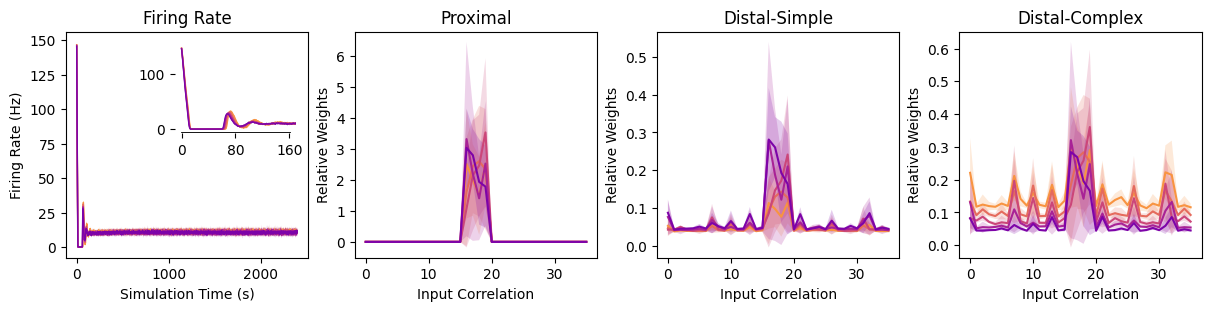

In [ ]:
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]
num_inputs = SourcePopulationGabor.num_inputs

fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
inset = ax[0].inset_axes([0.45, 0.55, 0.5, 0.4])
iedge = 1
for iratio in range(num_ratios):
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio, iedge], axis=1), axis=0, ax=ax[0], color=colors[iratio], linewidth=1.0)
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio, iedge], axis=1), axis=0, ax=inset, color=colors[iratio], linewidth=1.0)
    proximal_mean = np.mean(weights["proximal"][iratio, iedge], axis=1)  
    distal_simple_mean = np.mean(weights["distal-simple"][iratio, iedge], axis=1)
    distal_complex_mean = np.mean(weights["distal-complex"][iratio, iedge], axis=1)
    errorPlot(range(num_inputs), proximal_mean, axis=0, ax=ax[1], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(range(num_inputs), distal_simple_mean, axis=0, ax=ax[2], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(range(num_inputs), distal_complex_mean, axis=0, ax=ax[3], color=colors[iratio], alpha=0.2, linewidth=1.5)
ylim0 = ax[0].get_ylim()
inset.set_xlim(-10, 170)
inset.set_xticks([0, 80, 160])
inset.spines["top"].set_visible(False)
inset.spines["right"].set_visible(False)
inset.spines["left"].set_visible(False)
inset.spines["bottom"].set_visible(False)
inset.plot([0, 160], [ylim0[0], ylim0[0]], color="k", linewidth=2.0)
inset.set_ylim(ylim0)
ax[0].set_xlabel("Simulation Time (s)")
ax[0].set_ylabel("Firing Rate (Hz)")
ax[0].set_title("Firing Rate")
for axx, name in zip(ax[1:], ["Proximal", "Distal-Simple", "Distal-Complex"]):
    axx.set_xlabel("Input Correlation")
    axx.set_ylabel("Relative Weights")
    axx.set_title(name)
plt.show()

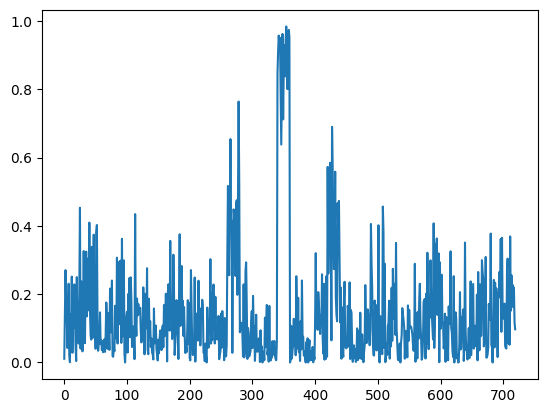

In [30]:
target = "distal-complex"
max_weight = results[0]["sim"].neurons[0].synapse_groups[target].max_weight
plt.plot(results[0]["sim"].neurons[0].synapse_groups[target].weights / max_weight)
plt.show()